## Projeto Final - DS2

### Import

In [232]:
import sys
import pickle
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
sys.path.append("../tools/")
warnings.filterwarnings("ignore")

In [233]:
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,train_test_split,\
                                    StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.externals import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedShuffleSplit, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [234]:
from time import time
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data, test_classifier
scaler = MinMaxScaler()

### Funções

In [307]:
def monta_grafico(feat_x, feat_y, titulo, dicionario, cor):
    # Criar um grafico scatter das fetures passadas no parametro
    features = ['poi', feat_x, feat_y]
    data = featureFormat(dicionario, features)
    
    plt.figure(figsize=(16,7))
    
    for point in data:
        x = point[1]
        y = point[2]
        if point[0]:
            if cor == 1:
                plt.scatter(x, y, color="red", marker="*")
            else:
                plt.scatter(x, y, color="green", marker=".")
        else:
            if cor == 1:
                plt.scatter(x, y, color='blue', marker=".")
            else:
                plt.scatter(x, y, color="orange", marker="*")
                
    
    plt.title(titulo, fontsize=20)
    plt.xlabel(feat_x, fontsize=18)
    plt.ylabel(feat_y, fontsize=18)    
    pic = feat_x + feat_y + '.png'
    plt.savefig(pic, transparent=True)
    plt.show()
    

def monta_feature(features_list):
    features_list = ['poi',
                 'salary',
                 'deferral_payments',
                 'total_payments',
                 'loan_advances',
                 'bonus',
                 'restricted_stock_deferred',
                 'deferred_income',
                 'total_stock_value',
                 'expenses',
                 'exercised_stock_options',
                 'other',
                 'long_term_incentive',
                 'restricted_stock',
                 'director_fees',
                 'to_messages',                
                 'from_poi_to_this_person',
                 'from_messages',
                 'from_this_person_to_poi',
                 'shared_receipt_with_poi']
    return features_list
    
def nova_feature(dataset, features_list):
    nova_feature = ["fraction_from_poi_email", "fraction_to_poi_email"]
    num_features = ["from_poi_to_this_person", "from_this_person_to_poi"]
    den_features = ["to_messages", "from_messages"]

    for x in dataset:
        data = dataset[x]

        for i, feature in enumerate(nova_feature):
            if data["poi"]:
                data[feature] = 'NaN'
            else:
                message_poi = data[num_features[i]]
                messages_all = data[den_features[i]]
                fracao_messages = calcula_fracao(message_poi, messages_all)
                data[feature] = fracao_messages

    return features_list + nova_feature


def testa_nova_feature(dataset, x, nova_feature):
    num_features = ["from_poi_to_this_person", "from_this_person_to_poi"]
    den_features = ["to_messages", "from_messages"]
    
    print x, "\n- {} = {:.4f} ({} / {})\n- {} = {:.4f} ({} / {})\n".format(nova_feature[0],dataset[x][nova_feature[0]],dataset[x][num_features[0]],dataset[x][den_features[0]],nova_feature[1], dataset[x][nova_feature[1]],dataset[x][num_features[1]],dataset[x][den_features[1]])
  
    
def pipeline_classificador(tipo, kbest, f_list):
    # Contruir um pipeline e tune parameters via GridSearchCV

    data = featureFormat(my_dataset, f_list, sort_keys=True)
    labels, features = targetFeatureSplit(data)

    # Usando o stratified shuffle split cross validation devido ao tamanho dos conjuntos de dados
    stratified_split_cross_validation = StratifiedShuffleSplit(labels, 500, test_size=0.3, random_state=42)

    # Build pipeline
    kbest = SelectKBest(k=kbest)
    scaler = MinMaxScaler()
    classifier = escolher_classificador(tipo)
    pipeline = Pipeline(steps=[('minmax_scaler', scaler), ('feature_selection', kbest), (tipo, classifier)])

    # Set parameters for random forest
    parameters = []
    if tipo == 'randomforest':
        parameters = dict(randomforest__n_estimators=[25, 50],
                          randomforest__min_samples_split=[2, 3, 4],
                          randomforest__criterion=['gini', 'entropy'])
    if tipo == 'logistic_regression':
        parameters = dict(logistic_regression__class_weight=['balanced'],
                          logistic_regression__solver=['liblinear'],
                          logistic_regression__C=range(1, 5),
                          logistic_regression__random_state=42)
    if tipo == 'decisiontree':
        parameters = dict(decisiontree__min_samples_leaf=range(1, 5),
                          decisiontree__max_depth=range(1, 5),
                          decisiontree__class_weight=['balanced'],
                          decisiontree__criterion=['gini', 'entropy'])

    # Get optimized parameters for F1-scoring metrics
    cv = GridSearchCV(pipeline, param_grid=parameters, scoring='f1', cv=stratified_split_cross_validation)
    t0 = time()
    cv.fit(features, labels)
    print 'Tuning Classifier: %r' % round(time() - t0, 3)

    return cv

def melhor_classificador(aux):
    # Função para escolher um tipo de classificador
    return {
        'randomforest': RandomForestClassifier(),
        'decisiontree': DecisionTreeClassifier(),
        'logistic_regression': LogisticRegression(),
        'gaussiannb': GaussianNB()
    }.get(aux)    

def calcula_fracao(message_poi, messages_all):
    calc_fracao = 0.    
    if message_poi != "NaN" and messages_all != "NaN":        
        calc_fracao = float(message_poi) / messages_all
    return calc_fracao

def sumariza_valores(dataset):
    df_list = []
    for key, y in dataset.items():
        df_list.append(y)
    
    df = pd.DataFrame(df_list, columns = dataset.items()[0][1].keys())

    for i in df.columns:
        df[i][df[i].apply(lambda i: True if str(i) == "NaN" else False)]=None
    
    df = df.convert_objects(convert_numeric=True)
    df.info()
    
def conta_poi(dataset):
    poi_count = 0
    for key, value in dataset.items():
        if value['poi']:
            poi_count += 1
    return poi_count

def accuracy(new_features,features_list):
    #Feature List
    features_list = monta_feature(features_list)
    if new_features == False:
        print features_list
        
    else:
        features_list = nova_feature(data_dict_woo, features_list)
        print ""
        print features_list
        print "Testando novos features adicionados:\n"
        testa_nova_feature(data_dict_woo, "DIETRICH JANET R", features_list[-2:])
        
    # Extraindo as features e os labels do conjunto de dados
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)    
        
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    print ""
    
    # Criando Min/Max Scaler
    from sklearn import preprocessing
    scaler = preprocessing.MinMaxScaler()
    # Scale Features
    features = scaler.fit_transform(features)
    
    skbest = SelectKBest(k=10)  # try best value to fit
    sk_trans = skbest.fit_transform(features_train, labels_train)
    indices = skbest.get_support(True)
    
    print "="*10,"skbest.scores_","="*10
    print skbest.scores_
    print "="*10, "="*(len("skbest.scores_")-2),"="*10
    print ""
    
    print "="*10,"features - score","="*10
    for index in indices:
        print 'features: %s score: %f' % (features_list[index + 1], skbest.scores_[index])
        
    print "="*10, "="*(len('features: %s score: %f')-2),"="*10
    print ""
    
    #print "GaussianNB"
    # GaussianNB
    clf = GaussianNB()
    clf.fit(features_train, labels_train)
    prediction = clf.predict(features_test)
    print "Accuracy GaussianNB  = {:.5f}".format(accuracy_score(prediction, labels_test))
    
    #print "KNeighborsClassifier"
    # KNeighborsClassifier
    clf = KNeighborsClassifier()
    clf = KNeighborsClassifier(algorithm = 'auto',leaf_size = 20,n_neighbors = 3,weights = 'uniform')
    clf.fit(features_train, labels_train)
    prediction = clf.predict(features_test)
    print "Accuracy KNeighborsClassifier  = {:.5f}".format(accuracy_score(prediction, labels_test))
    
    #print "SVC"
    # SVC
    clf = SVC(kernel = 'linear',max_iter = 10000,random_state = 42)
    clf.fit(features_train, labels_train)
    prediction = clf.predict(features_test)
    print "Accuracy SVC = {:.5f}".format(accuracy_score(prediction, labels_test))
    
    #print "AdaBoostClassifier"
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, class_weight='balanced'),
                             n_estimators=50, learning_rate=.8)
    clf.fit(features_train, labels_train)
    prediction = clf.predict(features_test)
    print "Accuracy AdaBoostClassifier = {:.5f}".format(accuracy_score(prediction, labels_test))
    
def adaboost_kbest(kbest_value, new_features,features_list):
    #Feature List
    features_list = monta_feature(features_list)
    if new_features == False:
        print "Default Features" 
#        print features_list 
        
    else:
        features_list = nova_feature(data_dict_woo, features_list)
        print "New Features"
#        print features_list
#        print "Testando novos features adicionados:\n"
#        testa_nova_feature(data_dict_woo, "DIETRICH JANET R", features_list[-2:])
        
    # Extraindo as features e os labels do conjunto de dados
    data = featureFormat(my_dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)    
        
    features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)
    print ""
    
    # Criando Min/Max Scaler
    from sklearn import preprocessing
    scaler = preprocessing.MinMaxScaler()
    # Scale Features
    features = scaler.fit_transform(features)
    
    skbest = SelectKBest(k=kbest_value)  # try best value to fit
    sk_trans = skbest.fit_transform(features_train, labels_train)
    indices = skbest.get_support(True)
        
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, min_samples_leaf=3, class_weight='balanced'),
                         n_estimators=50, learning_rate=.95)

    # Validate model precision, recall and F1-score
    test_classifier(clf, my_dataset, features_list)
    


### Task 1: Select what features you'll use.
- features_list is a list of strings, each of which is a feature name.
- The first feature must be "poi".

In [236]:
features_list = []
features_list = monta_feature(features_list)

In [237]:
print features_list

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']


In [238]:
#Feature List
#features_list = ['poi',
#                 'salary',
#                 'deferral_payments',
#                 'total_payments',
#                 'loan_advances',
#                 'bonus',
#                 'restricted_stock_deferred',
#                 'deferred_income',
#                 'total_stock_value',
#                 'expenses',
#                 'exercised_stock_options',
#                 'other',
#                 'long_term_incentive',
#                 'restricted_stock',
#                 'director_fees',
#                 'to_messages',                
#                 'from_poi_to_this_person',
#                 'from_messages',
#                 'from_this_person_to_poi',
#                 'shared_receipt_with_poi'] # You will need to use more features

In [239]:
# Carregando o conjunto de dados
with open("final_project_dataset.pkl", "r") as data_file:
#    data_dict = pickle.load(data_file)
    data_dict = pickle.load(open("final_project_dataset.pkl", "r"))
    

In [240]:
print "\nQuantidade total de registros: {}\nQuantidade total de features: {}".format(len(data_dict), len(data_dict["HAUG DAVID L"])) 
print "Quantidade de POI's: {}".format(conta_poi(data_dict)) 
print "Quantidade de não POI's: {}".format(len(data_dict) - conta_poi(data_dict))


Quantidade total de registros: 146
Quantidade total de features: 21
Quantidade de POI's: 18
Quantidade de não POI's: 128


In [241]:
df_enron = pd.DataFrame.from_dict(data_dict, orient = 'index')

In [242]:
df_enron.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [243]:
df_enron.sample(5)

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
SHERRIFF JOHN R,428780,3187,NaN,4335388,1835558,1500000,1293424,2103,NaN,3128982,...,NaN,92,1852186,23,False,NaN,NaN,554422,john.sherriff@enron.com,28
DERRICK JR. JAMES V,492375,2181,NaN,550981,8831913,800000,1787380,1401,-1787380,8831913,...,NaN,909,7482,20,False,NaN,-1284000,484000,james.derrick@enron.com,64
GLISAN JR BEN F,274975,873,NaN,1272284,384728,600000,393818,874,NaN,778546,...,NaN,16,200308,6,True,NaN,NaN,71023,ben.glisan@enron.com,52
FOY JOE,NaN,57,181755,181755,343434,NaN,NaN,2,NaN,343434,...,NaN,13,NaN,0,False,NaN,NaN,NaN,tracy.foy@enron.com,0
SCRIMSHAW MATTHEW,NaN,NaN,NaN,NaN,759557,NaN,NaN,NaN,NaN,759557,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,matthew.scrimshaw@enron.com,NaN


In [244]:
df_enron.tail()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
WINOKUR JR. HERBERT S,NaN,NaN,NaN,84992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,108579,-25000,NaN,NaN,NaN
WODRASKA JOHN,NaN,NaN,NaN,189583,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,189583,NaN,False,NaN,NaN,NaN,john.wodraska@enron.com,NaN
WROBEL BRUCE,NaN,NaN,NaN,NaN,139130,NaN,NaN,NaN,NaN,139130,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
YEAGER F SCOTT,158403,NaN,NaN,360300,8308552,NaN,3576206,NaN,NaN,11884758,...,NaN,NaN,147950,NaN,True,NaN,NaN,NaN,scott.yeager@enron.com,NaN
YEAP SOON,NaN,NaN,NaN,55097,192758,NaN,NaN,NaN,NaN,192758,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN


In [245]:
df_enron.describe().transpose()

,count,unique,top,freq
salary,146,95,NaN,51
to_messages,146,87,NaN,60
deferral_payments,146,40,NaN,107
total_payments,146,126,NaN,21
exercised_stock_options,146,102,NaN,44
bonus,146,42,NaN,64
restricted_stock,146,98,NaN,36
shared_receipt_with_poi,146,84,NaN,60
restricted_stock_deferred,146,19,NaN,128
total_stock_value,146,125,NaN,20


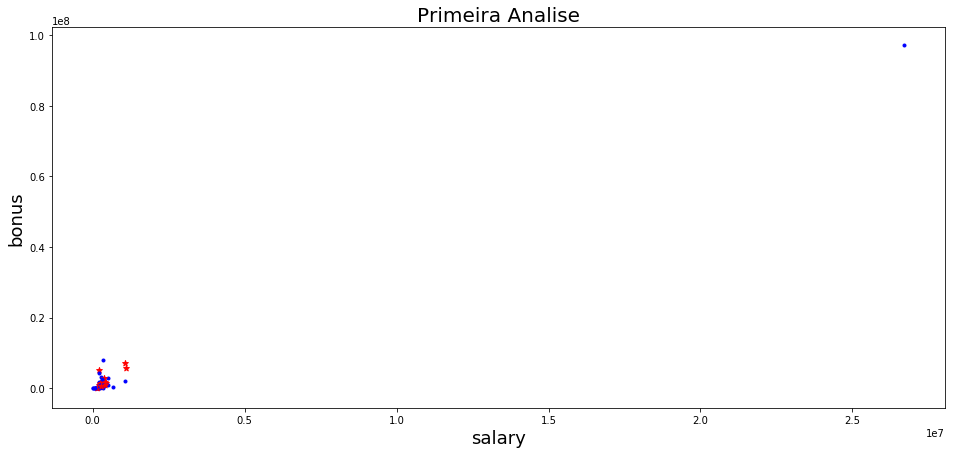

In [246]:
monta_grafico("salary", "bonus", "Primeira Analise",data_dict,1)

### Analise Exploratória
- Visulamente já é possível ver que muitas informações estão faltando
- Isso fica bem evidente quando analisamos por código
- Foi identificado o outliers TOTAL, que nos levou a investigar possíveis pois que não fossem pessoas

In [247]:
print "Dados: HAUG DAVID L:\n\n{}".format(data_dict["TOTAL"])
print "Dados: LOCKHART EUGENE E:\n\n{}".format(data_dict["LOCKHART EUGENE E"])
print "Dados: THE TRAVEL AGENCY IN THE PARK:\n\n{}".format(data_dict["THE TRAVEL AGENCY IN THE PARK"])

Dados: HAUG DAVID L:

{'salary': 26704229, 'to_messages': 'NaN', 'deferral_payments': 32083396, 'total_payments': 309886585, 'exercised_stock_options': 311764000, 'bonus': 97343619, 'restricted_stock': 130322299, 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': -7576788, 'total_stock_value': 434509511, 'expenses': 5235198, 'loan_advances': 83925000, 'from_messages': 'NaN', 'other': 42667589, 'from_this_person_to_poi': 'NaN', 'poi': False, 'director_fees': 1398517, 'deferred_income': -27992891, 'long_term_incentive': 48521928, 'email_address': 'NaN', 'from_poi_to_this_person': 'NaN'}
Dados: LOCKHART EUGENE E:

{'salary': 'NaN', 'to_messages': 'NaN', 'deferral_payments': 'NaN', 'total_payments': 'NaN', 'exercised_stock_options': 'NaN', 'bonus': 'NaN', 'restricted_stock': 'NaN', 'shared_receipt_with_poi': 'NaN', 'restricted_stock_deferred': 'NaN', 'total_stock_value': 'NaN', 'expenses': 'NaN', 'loan_advances': 'NaN', 'from_messages': 'NaN', 'other': 'NaN', 'from_this_person_

### Task 2: Remove outliers

In [248]:
# Removendo outliers
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict_woo = pickle.load(data_file)

print "Quantidade total de registros Com outliers: {}\n".format(len(data_dict_woo))    
    
data_dict_woo.pop('TOTAL', None) #Não é um funcionário 
data_dict_woo.pop('LOCKHART EUGENE E', None) #Não é um funcionário 
data_dict_woo.pop('THE TRAVEL AGENCY IN THE PARK', None) #Não é um funcionário 

print "Quantidade total de registros Sem outliers: {}\n".format(len(data_dict_woo))

Quantidade total de registros Com outliers: 146

Quantidade total de registros Sem outliers: 143



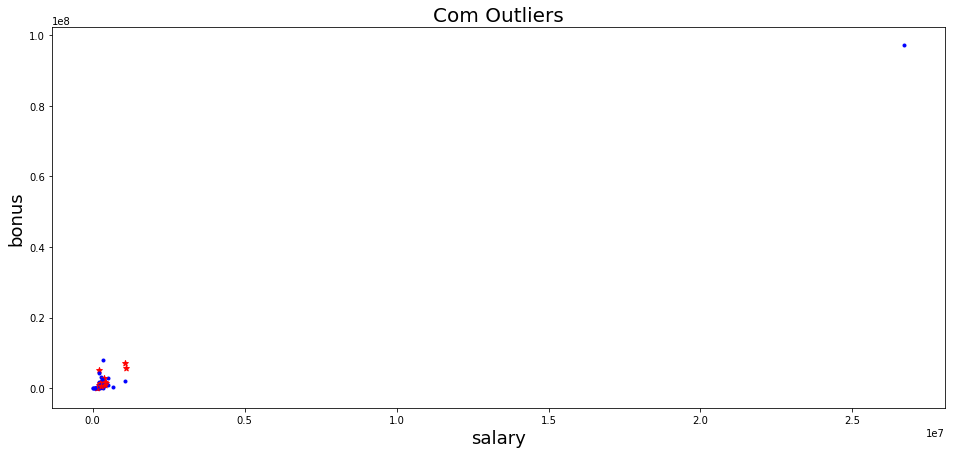

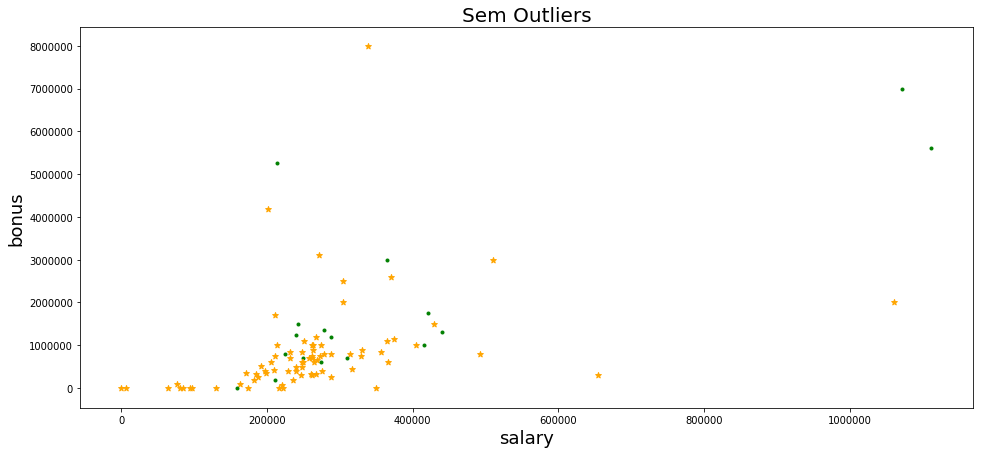

In [249]:
monta_grafico("salary", "bonus", "Com Outliers",data_dict,1)
monta_grafico("salary", "bonus", "Sem Outliers",data_dict_woo,2)

In [250]:
df_enron_woo = pd.DataFrame.from_dict(data_dict_woo, orient = 'index')
df_enron_woo.describe().transpose()

,count,unique,top,freq
salary,143,94,NaN,49
to_messages,143,87,NaN,57
deferral_payments,143,39,NaN,105
total_payments,143,124,NaN,20
exercised_stock_options,143,101,NaN,42
bonus,143,41,NaN,62
restricted_stock,143,97,NaN,34
shared_receipt_with_poi,143,84,NaN,57
restricted_stock_deferred,143,18,NaN,126
total_stock_value,143,124,NaN,18


In [251]:
df_enron_woo.head(20) 

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN
BAZELIDES PHILIP J,80818,NaN,684694,860136,1599641,NaN,NaN,NaN,NaN,1599641,...,NaN,NaN,874,NaN,False,NaN,NaN,93750,NaN,NaN
BECK SALLY W,231330,7315,NaN,969068,NaN,700000,126027,2639,NaN,126027,...,NaN,4343,566,386,False,NaN,NaN,NaN,sally.beck@enron.com,144
BELDEN TIMOTHY N,213999,7991,2144013,5501630,953136,5249999,157569,5521,NaN,1110705,...,NaN,484,210698,108,True,NaN,-2334434,NaN,tim.belden@enron.com,228
BELFER ROBERT,NaN,NaN,-102500,102500,3285,NaN,NaN,NaN,44093,-44093,...,NaN,NaN,NaN,NaN,False,3285,NaN,NaN,NaN,NaN
BERBERIAN DAVID,216582,NaN,NaN,228474,1624396,NaN,869220,NaN,NaN,2493616,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,david.berberian@enron.com,NaN


In [252]:
sumariza_valores(data_dict_woo)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 21 columns):
salary                       94 non-null float64
to_messages                  86 non-null float64
deferral_payments            38 non-null float64
total_payments               123 non-null float64
exercised_stock_options      101 non-null float64
bonus                        81 non-null float64
restricted_stock             109 non-null float64
shared_receipt_with_poi      86 non-null float64
restricted_stock_deferred    17 non-null float64
total_stock_value            125 non-null float64
expenses                     94 non-null float64
loan_advances                3 non-null float64
from_messages                86 non-null float64
other                        91 non-null float64
from_this_person_to_poi      86 non-null float64
poi                          143 non-null bool
director_fees                16 non-null float64
deferred_income              48 non-null float64
long_term_in

In [253]:
#df_graph_enron = df_enron_woo.copy()
df_graph_enron = df_enron_woo.describe().transpose()

In [254]:
df_graph_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, salary to from_poi_to_this_person
Data columns (total 4 columns):
count     21 non-null object
unique    21 non-null object
top       21 non-null object
freq      21 non-null object
dtypes: object(4)
memory usage: 840.0+ bytes


In [255]:
# Processo de criação de coluna com a diferença entre o total de registros unicos
#e registros duplicados/Não atribuídos

nan_dupl_col = []


def nan_dupl(reg):
    qty_nan_dupl = reg['count'] - reg['unique']
    nan_dupl_col.append(qty_nan_dupl)    
        
df_graph_enron.apply(nan_dupl, axis=1)
df_graph_enron['nan_dupl'] = nan_dupl_col 

In [256]:
df_graph_enron.drop(['count', 'top', 'freq'], axis=1, inplace=True)

df_graph_enron.head()

,unique,nan_dupl
salary,94,49
to_messages,87,56
deferral_payments,39,104
total_payments,124,19
exercised_stock_options,101,42


In [257]:
df_graph_enron.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, salary to from_poi_to_this_person
Data columns (total 2 columns):
unique      21 non-null object
nan_dupl    21 non-null int64
dtypes: int64(1), object(1)
memory usage: 504.0+ bytes


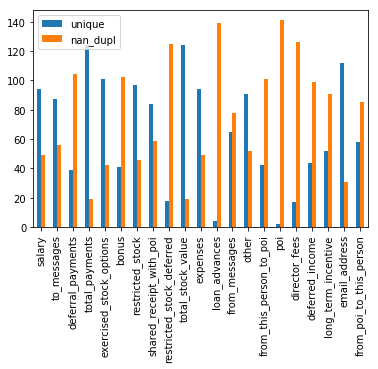

In [258]:
df_graph_enron.plot.bar()

In [259]:
labels_graph = list(df_graph_enron.index.values) 
print labels_graph

['salary', 'to_messages', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus', 'restricted_stock', 'shared_receipt_with_poi', 'restricted_stock_deferred', 'total_stock_value', 'expenses', 'loan_advances', 'from_messages', 'other', 'from_this_person_to_poi', 'poi', 'director_fees', 'deferred_income', 'long_term_incentive', 'email_address', 'from_poi_to_this_person']


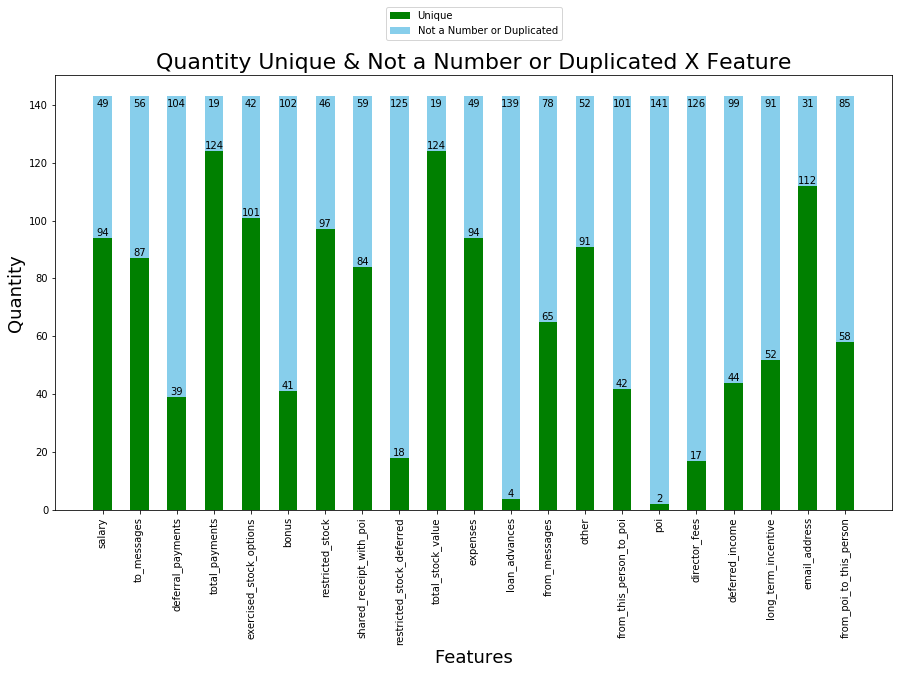

In [260]:

bar_1 = df_graph_enron['unique']
bar_2 = df_graph_enron['nan_dupl']
x_pos = np.arange(len(bar_1))

plt2 = plt

plt.figure(figsize=(15,8))

#plt.rcParams["figure.figsize"] = [15,8]
#plt.rcParams["legend.frameon"] = True
#plt.rcParams["legend.handletextpad"] = 1
#plt.rcParams["legend.borderaxespad"] = 60

first_bar = plt.bar(x_pos, bar_1, 0.5, color='green')
second_bar = plt.bar(x_pos, bar_2, 0.5, color='skyblue', bottom=bar_1)
plt.title('Quantity Unique & Not a Number or Duplicated X Feature', fontsize=22)
plt.xlabel('Features', fontsize=18)
plt.ylabel('Quantity', fontsize=18)

# Definir posição e labels no eixo X
plt.xticks(x_pos, (labels_graph), rotation=90)

def autolabel(rects, xpos='center'):
    """
    Attach a text label above each bar in *rects*, displaying its height.

    *xpos* indicates which side to place the text w.r.t. the center of
    the bar. It can be one of the following {'center', 'right', 'left'}.
    """

    xpos = xpos.lower()  # normalize the case of the parameter
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.57, 'left': 0.43}  # x_txt = x + w*off

    
    if rects == first_bar:
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()*offset[xpos], 1.00*height,
                    '{}'.format(height), ha=ha[xpos], va='bottom')
    else:
        for rect in rects:
            height = rect.get_height()
            plt.text(rect.get_x() + rect.get_width()*offset[xpos], 1.00*138.5,
                    '{}'.format(height), ha=ha[xpos], va='bottom')
            

autolabel(first_bar, "center")
autolabel(second_bar, "center")

plt.legend(labels=['Unique','Not a Number or Duplicated'], loc=8, borderaxespad = 47 )

plt.show()

### Task 3: Create new feature(s)

In [283]:
# Salvando o conjunto de dados
#df_enron_woo = pd.DataFrame.from_dict(data_dict_woo, orient = 'index')
#df_enron_woo.replace(to_replace='NaN', value=0.0, inplace=True)
my_dataset = data_dict_woo
#my_dataset = df_enron_woo.to_dict('index')

In [284]:
#Feature List
features_list = ['poi',
                 'salary',
                 'deferral_payments',
                 'total_payments',
                 'loan_advances',
                 'bonus',
                 'restricted_stock_deferred',
                 'deferred_income',
                 'total_stock_value',
                 'expenses',
                 'exercised_stock_options',
                 'other',
                 'long_term_incentive',
                 'restricted_stock',
                 'director_fees',
                 'to_messages',                
                 'from_poi_to_this_person',
                 'from_messages',
                 'from_this_person_to_poi',
                 'shared_receipt_with_poi'] # You will need to use more features

features_list = nova_feature(data_dict_woo, features_list)
print features_list


['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'fraction_from_poi_email', 'fraction_to_poi_email']


In [285]:
print "Testando novos features adicionados:\n"
testa_nova_feature(data_dict_woo, "DIETRICH JANET R", features_list[-2:])

Testando novos features adicionados:

DIETRICH JANET R 
- fraction_from_poi_email = 0.1186 (305 / 2572)
- fraction_to_poi_email = 0.2222 (14 / 63)



In [286]:
# Extraindo as features e os labels do conjunto de dados
data = featureFormat(my_dataset, features_list, sort_keys = True)
labels, features = targetFeatureSplit(data)


In [287]:
# Criando Min/Max Scaler
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
# Scale Features
features = scaler.fit_transform(features)

### Task 4: Try a varity of classifiers
- Please name your classifier clf for easy export below.
- Note that if you want to do PCA or other multi-stage operations,
- you'll need to use Pipelines. For more info: http://scikit-learn.org/stable/modules/pipeline.html

In [288]:
#features_train, features_test, labels_train, labels_test = \
#    train_test_split(features, labels, test_size=0.3, random_state=42)

In [289]:
#skbest = SelectKBest(k=10)  # try best value to fit
#sk_trans = skbest.fit_transform(features_train, labels_train)
#indices = skbest.get_support(True)
#print skbest.scores_

In [290]:
#for index in indices:
#     print 'features: %s score: %f' % (features_list[index + 1], skbest.scores_[index])
#print ""

In [291]:
##print "GaussianNB"
## GaussianNB
#clf = GaussianNB()
#clf.fit(features_train, labels_train)
#prediction = clf.predict(features_test)
#print ("Accuracy GaussianNB =", accuracy_score(prediction0, labels_test))


In [292]:
#print "KNeighborsClassifier"
# KNeighborsClassifier
#clf = KNeighborsClassifier()
#clf = KNeighborsClassifier(algorithm = 'auto',leaf_size = 20,n_neighbors = 3,weights = 'uniform')
#clf.fit(features_train, labels_train)
#prediction = clf.predict(features_test)
#print "Accuracy KNeighborsClassifier =", accuracy_score(prediction, labels_test)

In [293]:
#print "SVC"
# SVC
#clf = SVC(kernel = 'linear',max_iter = 10000,random_state = 42)
#clf.fit(features_train, labels_train)
#prediction = clf.predict(features_test)
#print "Accuracy SVC =", accuracy_score(prediction, labels_test)

In [294]:
#print "AdaBoostClassifier"
#clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, class_weight='balanced'),
#                         n_estimators=50, learning_rate=.8)
#clf.fit(features_train, labels_train)
#prediction = clf.predict(features_test)
#print "Accuracy AdaBoostClassifier =", accuracy_score(prediction, labels_test)

In [295]:
accuracy(False, features_list)

['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi']

========== skbest.scores_ ==========
[1.58587309e+01 9.98239959e-03 8.95913665e+00 7.03793280e+00
 3.07287746e+01 7.27124110e-01 8.79220385e+00 1.06338520e+01
 4.18072148e+00 9.68004143e+00 3.20445914e+00 7.55511978e+00
 8.05830631e+00 1.64109793e+00 2.61618300e+00 4.95866668e+00
 4.35374099e-01 1.11208239e-01 1.07225708e+01]
========== ============ ==========

========== features - score ==========
features: salary score: 15.858731
features: total_payments score: 8.959137
features: loan_advances score: 7.037933
features: bonus score: 30.728775
features: deferred_income score: 8.792204
features: total_stock_value score

In [296]:
accuracy(True, features_list)


['poi', 'salary', 'deferral_payments', 'total_payments', 'loan_advances', 'bonus', 'restricted_stock_deferred', 'deferred_income', 'total_stock_value', 'expenses', 'exercised_stock_options', 'other', 'long_term_incentive', 'restricted_stock', 'director_fees', 'to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi', 'shared_receipt_with_poi', 'fraction_from_poi_email', 'fraction_to_poi_email']
Testando novos features adicionados:

DIETRICH JANET R 
- fraction_from_poi_email = 0.1186 (305 / 2572)
- fraction_to_poi_email = 0.2222 (14 / 63)


========== skbest.scores_ ==========
[1.58587309e+01 9.98239959e-03 8.95913665e+00 7.03793280e+00
 3.07287746e+01 7.27124110e-01 8.79220385e+00 1.06338520e+01
 4.18072148e+00 9.68004143e+00 3.20445914e+00 7.55511978e+00
 8.05830631e+00 1.64109793e+00 2.61618300e+00 4.95866668e+00
 4.35374099e-01 1.11208239e-01 1.07225708e+01 3.90983633e+00
 2.88172795e+00]
========== ============ ==========

========== features - score ==

In [297]:
data = {"Algorithms":["GaussianNB","KNeighborsClassifier",
"SVC","AdaBoostClassifier",
"GaussianNB","KNeighborsClassifier",
"SVC","AdaBoostClassifier"                     ],
"New Features":["N","N","N","N","S","S","S","S"],
"Accuracy":[0.88372,0.90698,0.88372,0.81395,0.88372,0.90698,0.88372,0.95349],
}
#Accuracy GaussianNB  = 0.88372
#Accuracy KNeighborsClassifier  = 0.90698
#Accuracy SVC = 0.88372
#Accuracy AdaBoostClassifier = 0.81395
#Accuracy GaussianNB  = 0.88372
#Accuracy KNeighborsClassifier  = 0.90698
#Accuracy SVC = 0.88372
#Accuracy AdaBoostClassifier = 0.95349
algorithms = pd.DataFrame(data, columns = ["Algorithms", "New Features", "Accuracy",])
algorithms

,Algorithms,New Features,Accuracy
0,GaussianNB,N,0.88372
1,KNeighborsClassifier,N,0.90698
2,SVC,N,0.88372
3,AdaBoostClassifier,N,0.81395
4,GaussianNB,S,0.88372
5,KNeighborsClassifier,S,0.90698
6,SVC,S,0.88372
7,AdaBoostClassifier,S,0.95349


### Task 5: Tune your classifier
    Tune your classifierto achieve better than .3 precision and recall 
    using our testing script. Check the tester.py script in the final project
    folder for details on the evaluation method, especially the test_classifier
    function. Because of the small size of the dataset, the script uses
    stratified shuffle split cross validation. For more info:

In [212]:
# Testar os classificadores
#print '\n'
#print '########## Testar and Tunning Classifiers ##########'
# See "pipeline_classificador" for MinMaxScaling, SelectKBest and Logistic Regression tuning

# Classifiers tested but not using - Logistic_Regression, RandomForestClassifier, DecisionTreeClassifier

#cross_val = pipeline_classificador('randomforest',9, features_list)
#print 'Melhores Parametros: ', cross_val.best_params_
#clf = cross_val.best_estimator_



In [281]:
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, min_samples_leaf=2, class_weight='balanced'),
                         n_estimators=50, learning_rate=.8)

#clf.fit(features_train, labels_train)
#prediction = clf.predict(features_test)
#print "Accuracy AdaBoostClassifier =", accuracy_score(prediction, labels_test)


# Validate model precision, recall and F1-score
test_classifier(clf, my_dataset, features_list)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.8, n_estimators=50, random_state=None)
	Accuracy: 0.91393	Precision: 0.71014	Recall: 0.59900	F1: 0.64985	F2: 0.61835
	Total predictions: 15000	True positives: 1198	False positives:  489	False negatives:  802	True negatives: 12511



In [308]:
for k in range(1,11):
    print "========== kbest = ", k, "="*10, "Ini"
    
    t0 = time()
    adaboost_kbest(k, True, features_list)
    
    print "tempo de treinamento:", round(time()-t0, 3), "s"
    print "========== kbest = ", k, "="*10,"Fim"
    
    

========== kbest =  1 ========== Ini
New Features

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.95, n_estimators=50, random_state=None)
	Accuracy: 0.91247	Precision: 0.70313	Recall: 0.59450	F1: 0.64427	F2: 0.61346
	Total predictions: 15000	True positives: 1189	False positives:  502	False negatives:  811	True negatives: 12498

tempo de treinamento: 76.154 s
========== kbest =  1 ========== Fim
========== kbest =  2 ========== Ini
New Features

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=N

In [309]:
for k in range(1,11):
    print "========== kbest = ", k, "="*10, "Ini"
    t0 = time()
    adaboost_kbest(k, False, features_list)
    print "tempo de treinamento:", round(time()-t0, 3), "s"
    print "========== kbest = ", k, "="*10,"Fim"

========== kbest =  1 ========== Ini
Default Features

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.95, n_estimators=50, random_state=None)
	Accuracy: 0.83180	Precision: 0.35888	Recall: 0.33250	F1: 0.34519	F2: 0.33746
	Total predictions: 15000	True positives:  665	False positives: 1188	False negatives: 1335	True negatives: 11812

tempo de treinamento: 75.729 s
========== kbest =  1 ========== Fim
========== kbest =  2 ========== Ini
Default Features

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=1,
            max_features=None, max_leaf

### Task 6: Dump your classifier, dataset, and features_list
Dump your classifier, dataset, and features_list so anyone can check your results. 
You do not need to change anything below, but make sure that the version of
poi_id.py that you submit can be run on its own and generates the necessary .pkl 
files for validating your results.

In [103]:
dump_classifier_and_data(clf, my_dataset, features_list)

### Refrências
https://datascience.stackexchange.com/questions/13410/parameters-in-gridsearchcv-in-scikit-learn/13414

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

https://stackoverflow.com/questions/45444953/parameter-values-for-parameter-n-estimators-need-to-be-a-sequence

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html

https://stackoverflow.com/questions/45969390/difference-between-stratifiedkfold-and-stratifiedshufflesplit-in-sklearn

https://www.featurelabs.com/blog/feature-engineering-vs-feature-selection/

http://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

http://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html

https://en.wikipedia.org/wiki/Enron

http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html

http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py

https://en.wikipedia.org/wiki/Precision_and_recall

http://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

https://datascience.stackexchange.com/questions/21877/how-to-use-the-output-of-gridsearch

https://stats.stackexchange.com/questions/62621/recall-and-precision-in-classification

https://stackoverflow.com/questions/49147774/what-is-random-state-in-sklearn-model-selection-train-test-split-example

@Jefferson Aparecido Rodrigues ( Aluno Udacity que me deu umas dicas, me destravando em alguns pontos )